In [56]:
%conda install pandas
import pandas as pd
import numpy as np
%pip install --upgrade scipy
import scipy
%pip install plotly
import plotly.graph_objects as go
%pip install nbformat --upgrade

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

Solving environment...
Solving took 8.22289999985695 seconds
All requested packages already installed.
Process pip requirements ...

Requirement scipy already handled by conda/micromamba/mamba.
Process pip requirements ...

Requirement plotly already satisfied.
Process pip requirements ...

Requirement nbformat already satisfied.


In [65]:
"""
Produce dataset
Current Stock Price : S=100
Risk free rate      : r=0.02 (2%)
True volatility     : s=0.2  (20%)
Strike prices       : K={80,90,100,110,120} 
Time to Maturity    : TtM={ 0.25, 0.5, 0.75, 1.0} [in yrs]
"""
S= 100
r= 0.02
s=0.2
K= np.array([80, 90, 100, 110, 120])
TtM = np.array([0.25, 0.5, 0.75, 1.0])
def BS_formula(S, r, s, K, TtM):
    d1 =  (np.log(S/K) + (r+s**2/2)*TtM)/(s*np.sqrt(TtM))
    d2 =  d1 - s*np.sqrt(TtM)
    Phi1 = scipy.stats.norm.cdf(d1)
    Phi2 = scipy.stats.norm.cdf(d2)
    C =  S*Phi1 - K * np.exp(-r*TtM) * Phi2
    return C

#Building true data dataframe
data = []
for k in K:
    for t in TtM:
        call_price = BS_formula(S, r, s, k, t)
        data.append({'Strike': k, 'TtM': t, 'CallPrice': call_price})
df = pd.DataFrame(data)
df



,Strike,TtM,CallPrice
0,80,0.25,20.433455
1,80,0.50,21.056156
2,80,0.75,21.785163
3,80,1.00,22.542853
4,90,0.25,11.093090
5,90,0.50,12.453918
6,90,0.75,13.685352
7,90,1.00,14.806507
8,100,0.25,4.232160
9,100,0.50,6.120654


In [66]:
def implied_Volatility(C_market, S, K, T, r):
    #Solve the volatility of the dataset using the scipy brentq
    try:
        return scipy.optimize.brentq( lambda sig: BS_formula(S,r,sig,K,T) - C_market,
                               1e-7, 10.0, # sigma [1e-6, 10.0]
                               maxiter=10000
                             )
    except ValueError:
        return np.nan #No solution found
df['ImpliedVol'] = df.apply( lambda row: implied_Volatility( row['CallPrice'], S, row['Strike'], row['TtM'], r), axis=1).round(4)


print(df)

    Strike   TtM  CallPrice  ImpliedVol
0       80  0.25  20.433455         0.2
1       80  0.50  21.056156         0.2
2       80  0.75  21.785163         0.2
3       80  1.00  22.542853         0.2
4       90  0.25  11.093090         0.2
5       90  0.50  12.453918         0.2
6       90  0.75  13.685352         0.2
7       90  1.00  14.806507         0.2
8      100  0.25   4.232160         0.2
9      100  0.50   6.120654         0.2
10     100  0.75   7.619892         0.2
11     100  1.00   8.916037         0.2
12     110  0.25   1.043940         0.2
13     110  0.50   2.472942         0.2
14     110  0.75   3.765564         0.2
15     110  1.00   4.943867         0.2
16     120  0.25   0.166663         0.2
17     120  0.50   0.831091         0.2
18     120  0.75   1.669205         0.2
19     120  1.00   2.546926         0.2


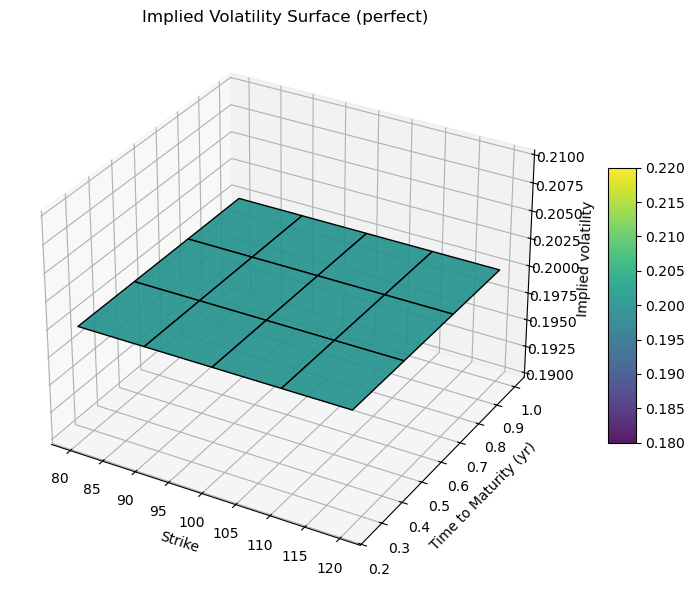

In [67]:
def plot_implied_volatitility(df,noise=None):
    df_sorted = df.sort_values(by=['TtM','Strike'])
    pivot     = df_sorted.pivot(index='TtM', columns='Strike', values='ImpliedVol')

    X = pivot.columns.values
    Y = pivot.index.values
    Z = pivot.values 
    X, Y = np.meshgrid( X, Y)

    fig = plt.figure(figsize=(10,6))
    ax  = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(X, Y, Z, cmap = cm.viridis, edgecolor='k', alpha=0.9)

    ax.set_xlabel("Strike")
    ax.set_ylabel("Time to Maturity (yr)")
    ax.set_zlabel("Implied volatility")
    ax.set_title(f"Implied Volatility Surface (noise={noise}%)" if noise else "Implied Volatility Surface (perfect)")
    fig.colorbar( surf, shrink= 0.5, aspect=10)
    plt.tight_layout()
    plt.show()

plot_implied_volatitility(df)


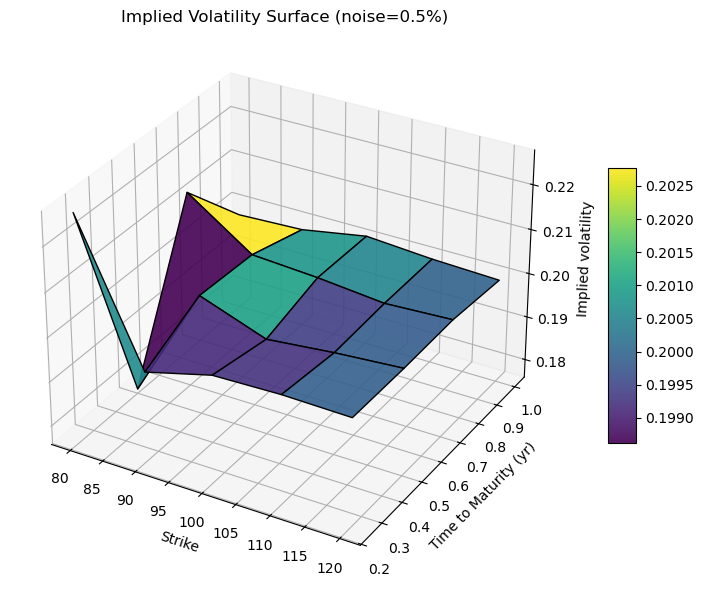

,Strike,TtM,CallPrice,ImpliedVol,NoisyPrice
0,80,0.25,20.433455,0.2266,20.481621
1,80,0.50,21.056156,0.1769,20.930769
2,80,0.75,21.785163,0.2124,21.941222
3,80,1.00,22.542853,0.1979,22.507613
4,90,0.25,11.093090,0.1961,11.053122
5,90,0.50,12.453918,0.2029,12.509161
6,90,0.75,13.685352,0.2023,13.744171
7,90,1.00,14.806507,0.1985,14.759384
8,100,0.25,4.232160,0.2000,4.232492
9,100,0.50,6.120654,0.1975,6.052021


In [68]:
#Now add noises of 0.5% for reproducibility seed 1234
np.random.seed(1234)
noise = np.random.normal(0, 0.005 * df['CallPrice'])  # 0.5% noise

df['NoisyPrice'] = df['CallPrice'] + noise

df['ImpliedVol'] = df.apply( lambda row: implied_Volatility( row['NoisyPrice'], S, row['Strike'], row['TtM'], r), axis=1).round(4)
plot_implied_volatitility(df, noise=0.5)
df


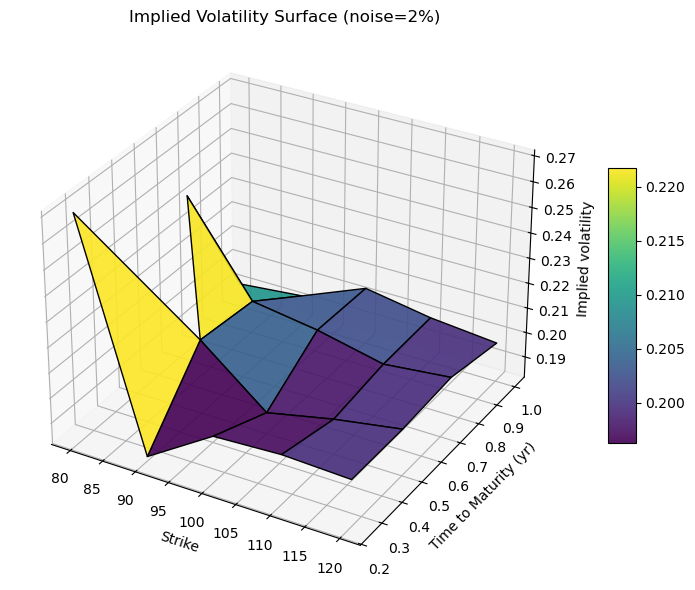

,Strike,TtM,CallPrice,ImpliedVol,NoisyPrice
0,80,0.25,20.433455,0.2704,20.626116
1,80,0.50,21.056156,NaN,20.554609
2,80,0.75,21.785163,0.2442,22.409398
3,80,1.00,22.542853,0.1913,22.401892
4,90,0.25,11.093090,0.1835,10.933219
5,90,0.50,12.453918,0.2114,12.674891
6,90,0.75,13.685352,0.2091,13.920628
7,90,1.00,14.806507,0.1938,14.618013
8,100,0.25,4.232160,0.2001,4.233488
9,100,0.50,6.120654,0.1902,5.846120


In [69]:
#Now add noises of 0.5% for reproducibility seed 1234
np.random.seed(1234)
noise = np.random.normal(0, 0.02 * df['CallPrice'])  # 0.5% noise

df['NoisyPrice'] = df['CallPrice'] + noise

df['ImpliedVol'] = df.apply( lambda row: implied_Volatility( row['NoisyPrice'], S, row['Strike'], row['TtM'], r), axis=1).round(4)
plot_implied_volatitility(df, noise=2)
df
